# Построение решающего дерева

Решающее дерево использует гиперплоскости параллельные осям признаков, чтобы делить данные на два подпространства или региона. Таким образом решающее дерево делит весь набор данных $D$ на два $D_1$ и $D_2$. Затем каждый из этих наборов продолжает делиться до тех пор, пока все объекты набора на новом этапе деления не будет соответствовать одному классу.

Классификация тестовой точки - это оценка, какому подпространству она принадлежит, осуществляется поиск листа дерева, в которое попадает тестовый объект.

Решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. 

## Параллельные гиперплоскости

$$h(\pmb{\text{x}}):\omega^T \pmb{\text{x}} + b = 0$$

где $\omega \in R^d$ - это вектор весов нормальный к гиперплоскости и $b$ - смещение гиперплоскости от начала координат.
В связи с тем, что в дереве решений гиперплоскости параллельные осям, то вектор нормали должен быть параллелен одной из осей $X_j$. Отсюда следует, что вектор весов $\omega$ является одни из стандартных базисных векторов ${e_1, e_2, ..., e_d}$, где $e_i \in R^d$ имеет единицу в $j$-ой пространстве, и ноль в остальных. 

$$h(\pmb{\text{x}}):\pmb{\text{e}}_j^T \pmb{\text{x}} + b = 0$$
$$h(\pmb{\text{x}}):X_j + b = 0$$

Таким образом, условия во внутренних вершинах получаются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x_j$ левее порога $t$:

$$[X_j \leq t]$$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

## Чистота

Чистота выделенного региона $R_j$ определяется как смесь классов различных объектов в соответствующих данных $D_j$. 

$$purity(D_j) = max_i \left\{ \frac{n_{ji}}{n_j} \right\}$$

где $n_j = |D_j|$ - количество объектов в регионе $R_j$ и $n_{ji}$ количество объектов в $D_j$ с классом $c_i$


In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np

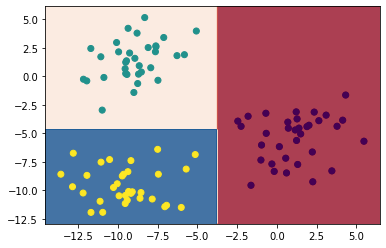

In [2]:
x, y = make_blobs(centers = 3, cluster_std=2)
plt.scatter(x[:,0], x[:,1], c = y)

from sklearn.tree import DecisionTreeClassifier

h = .02
x_min, x_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
y_min, y_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
clf = DecisionTreeClassifier()
clf.fit(x, y)
Z = clf.predict(np.transpose(np.vstack([xx.ravel(), yy.ravel()])))
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

Отметим, что решающее дерево может хорошо отделять каждый класс от всех остальных. Каждая разделяющая поверхность является кусочно-постоянной.

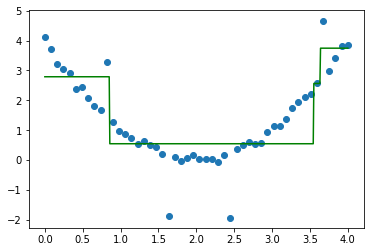

In [3]:
x = np.linspace(0, 4, 50)
y = np.array([(it - 2) ** 2 + (np.random.random() - 0.5) / 3  for it in x])
y[10] += 2
y[20] -= 2
y[30] -= 2
y[45] += 2
plt.scatter(x, y)

from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth = 2)
clf.fit(x.reshape(-1,1), y.reshape(-1,1))

x_pred = np.linspace(0, 4, 500)
y_pred = clf.predict(x_pred.reshape(-1,1))
plt.plot(x_pred, y_pred, color='g')

## Построение решающего дерева

Существую множество алгоритмов построения решающего дерева:
- ID3, алгоритм использует в качестве критерия прирост информации, либо критерий Джинни;
- C4.5, модифицированный алгоритм ID3;
- CART и его модификации.

Применяется жадный способ построения решающего дерева. Дерево ветвится пока этого не будет достаточно, чтобы разделить все данные.
В каждой вершине будет находиться простое условие для одного признака, которое будет сравнивать все элементы по некоторыму порогу $t$.

Запишем это следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

После того, как мы подобрали параметры $j$ и $t$. Это реально сделать, так их количество конечно. Множество $X_m$ объектов из выборки разбивается на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_r = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества, дерево будет углубляться в больше и больше.

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

### Алгоритм
**Decision Tree**($\textstyle{D}$, $\eta$, $\pi$):
1. $n \leftarrow |D|$ // количество объектов
2. $n_i \leftarrow |\{x_j| x_j \in D, y_j = c_i\}|$ // количетсво объектов каждого класса
3. $putity(D) \leftarrow max_i \left\{ \frac{n_{ji}}{n_j} \right\}$
4. **if** $n \leq \eta$ **or** $purity(D) \geq \pi$ **then**    
5. - $c^* \leftarrow arg max_{c_i} \left\{ \frac{n_{ji}}{n_j} \right\}$
6. - создать листовую вершину и присвоить ей значение класса $c^*$
7. - **return**
8. (точка_деления*, оценка*) $\leftarrow (None, 0)$ // инициализация точки разбиения
9. **foreach** $(признак X_j)$ **do**
10. - **if** $(X_j численный атрибут)$ **then**  
11. - - $(v, оценка) ← оценка\_численного\_атрибута (D, X j )$
12. - - **if** оценка $>$ оценка* **then** (точка_деления*, оценка*) $\leftarrow (X_j \leq v, оценка)$
13. - **if** $(X_j категориальный атрибут)$ **then**  
14. - - $(V, оценка) ← оценка\_категориального\_атрибута (D, X j )$
15. - - **if** оценка $>$ оценка* **then** (точка_деления*, оценка*) $\leftarrow (X_j \in V, оценка)$
16. $D_1 \leftarrow \{\pmb{\text{x}} \in D | \pmb{\text{x}} \text{ удовлетворяет точка_деления*} \}$
17. $D_0 \leftarrow \{\pmb{\text{x}} \in D | \pmb{\text{x}} \text{ не удовлетворяет точка_деления*} \}$
18. создать внутреннюю вершину точка_деления с двумя нодами $D_0$ и $D_1$
19. **Decision Tree**($D_1$); **Decision Tree**($D_0$).

## Критерии информативности

Функция ошибки:

$L(X_m, j, t) = \frac{|X_L|}{|X_m|}H(X_L) + \frac{|X_R|}{|X_m|}H(X_R)$

### Критерий для регрессии

В случае регрессии мы смотрим дисперсию распределения. В этой связи критерии информативности записываются следующим образом:
    
$H(X) = \frac{1}{|X|}\sum\limits_{i \in X}(y_i - \bar{y}(X))$, 

$\bar{y}= \frac{1}{|X|} \sum\limits_{i \in X}y_i$

### Критерий информативности Джинни

Критерий информативности для задачи классификации:
$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

Критерий информативности:

$H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$

Слагаемые неотрицательны и критерий тоже неотрицателен. Оптимум достигается только в том случае, если все объекты относятся к одному классу.

### Энтропийный критерий информативности

$H(X)=-\sum\limits_{k=1}^{K} p_k \ln{p_k}$

/home/vasily/.virtualenvs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


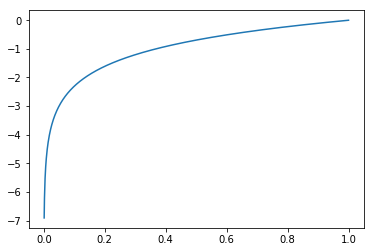

In [54]:
x = np.linspace(0, 1, 1000)
plt.plot(x, np.log(x))

### Категориальные признаки

Позволяет включать категориальные признаки в построение деревьев. Из каждой вершины может выходить до $n$ ребер, где $n$ - количество различных значений в категориальном атрибуте.
Порога для категориальных признаков нет. Критерий ошибки будет выглядеть следующим образом:

$L(X_m, j) = \sum\limits_{i=1}^{n}\frac{|X_i|}{|X_m|} H(X_i) \rightarrow \underset{j}{min}$

## Создание искусственных данных

Два случайных распределения

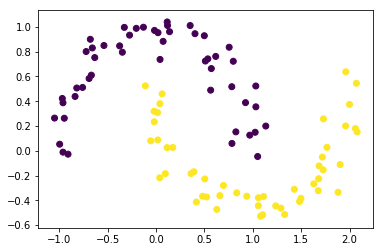

In [126]:
x, y = make_moons(noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)

# Построение классификационного дерева решений.

In [127]:
h = .02
x_min, x_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
y_min, y_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

In [128]:
def get_crit(atr, y):
    crit = []
    for it in np.sort(atr):
        X1 = y[atr <= it]
        X2 = y[atr > it]
        if len(X2):
            p0_1 = len(X1[X1 == 0]) / len(X1)
            p1_1 = len(X1[X1 == 1])/ len(X1)
            p0_2 = len(X2[X2 == 0]) / len(X2)
            p1_2 = len(X2[X2 == 1])/ len(X2)
            crit.append(len(X1) / len(atr) * (p0_1 * (1 - p0_1) + p1_1* (1 - p1_1)) + len(X2) / len(atr) * (p0_2 * (1 - p0_2) + p1_2* (1 - p1_2)))
    return crit

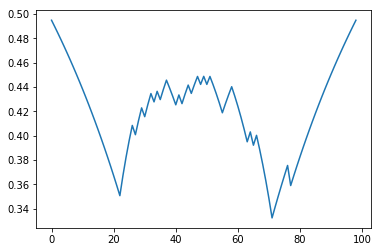

In [129]:
plt.plot(get_crit(x[:,0], y))

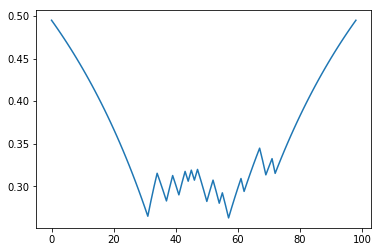

In [130]:
plt.plot(get_crit(x[:,1], y))

In [60]:
n = 1
t1 = np.sort(x[:,n])[np.argmin(get_crit(x[:,n], y))]

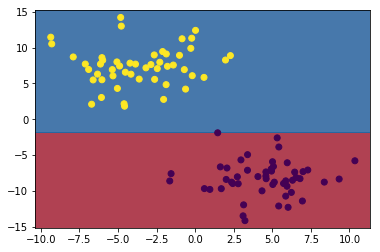

In [61]:
if n == 0:
    Z = np.array([int(it) for it in xx.ravel() > t1])
elif n == 1:
    Z = np.array([int(it) for it in yy.ravel() > t1])
Z = Z.reshape(xx.shape)
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

In [196]:
x1 = x[x[:,n] <= t1]
y1 = y[x[:,n] <= t1]
y1

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [197]:
x2 = x[x[:,n] > t1]
y2 = y[x[:,n] > t1]
y2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

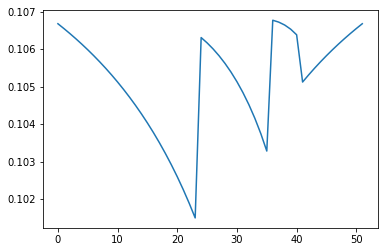

In [199]:
plt.plot(get_crit(x1[:,0], y1))

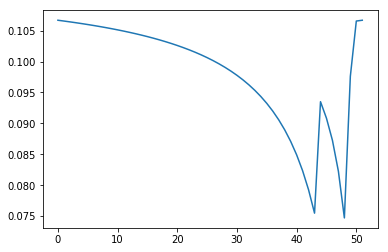

In [200]:
plt.plot(get_crit(x1[:,1], y1))

In [201]:
n = 1
t2 = np.sort(x1[:,n])[np.argmin(get_crit(x1[:,n], y1))]
t2

1.796836511430342

In [206]:
Z = (yy <= t1) & (yy <= t2).astype(int)

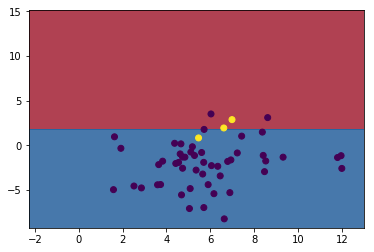

In [207]:
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x1[:,0], x1[:,1], c = y1)

In [166]:
x2_1 = x2[x2[:,n] <= t2]
y2_1 = y2[x2[:,n] <= t2]
y2_1

array([1, 0])

In [167]:
x2_2 = x2[x2[:,n] > t2]
y2_2 = y2[x2[:,n] > t2]
y2_2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

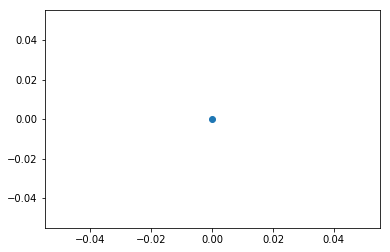

In [170]:
plt.plot(get_crit(x2_1[:,0], y2_1), marker='o')

## Готовая функция в sklearn построения решающего дерева

In [85]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
clf = DecisionTreeClassifier()

In [87]:
clf.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [88]:
Z = clf.predict(np.transpose(np.vstack([xx.ravel(), yy.ravel()])))

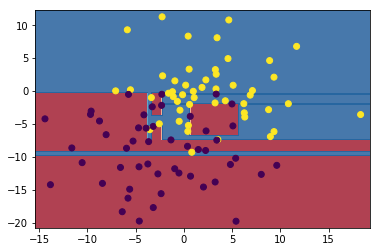

In [89]:
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

# Случайный лес

## Композиция алгоритмов

In [131]:
from sklearn.ensemble import RandomForestClassifier

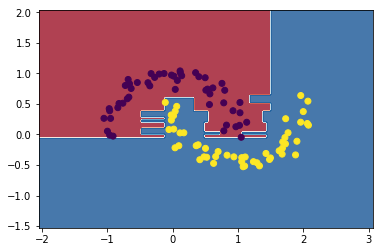

In [134]:
clf = RandomForestClassifier(n_estimators=5, bootstrap=False)
clf.fit(x, y)
Z = clf.predict(np.transpose(np.vstack([xx.ravel(), yy.ravel()])))
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

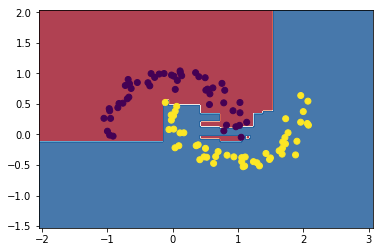

In [135]:
clf = RandomForestClassifier(n_estimators=5, bootstrap=True)
clf.fit(x, y)
Z = clf.predict(np.transpose(np.vstack([xx.ravel(), yy.ravel()])))
cm = plt.cm.RdBu
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

###